# xG Analysis of the English Premier League from 2014/2015 Season till the 2022/2023 Season Project

by Chrysovalanti Voutselas

In [1]:
import traceback
import numpy as np
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import time
import seaborn as sns
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import roc_curve, auc, mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import scipy.stats
import matplotlib as mpl
from mplsoccer.pitch import Pitch
from scipy.stats import binned_statistic_2d

# Project Goals/Questions to be answered:

- Teach the value of xG and explain what it is

- Is the sudden hype around xG real? Is it accurate when using it to predict goals? What factor plays the biggest part in generating an xG value?

- Do xG and xGA totals hold any value when looking at past standings placement?

- Does team spending lead to more points/titles won?

- How age impacts xG and xA value

- Visualising shots, goals and xG throughout 9 seasons

links/sources for things not directy shown in code, might be missing a few:

-https://statsbomb.com/soccer-metrics/expected-goals-xg-explained/

-https://soccermatics.readthedocs.io/en/latest/gallery/lesson2/plot_xGModelFit.html

-https://soccermatics.medium.com/the-geometry-of-shooting-ae7a67fdf760

-https://github.com/douglasbc/scraping-understat-dataset (player and game shot data)

-https://mplsoccer.readthedocs.io/en/latest/installation.html

-https://medium.com/@jordanpelletier1995/analyzing-age-curves-and-draft-pick-value-in-nhl-skaters-with-an-rapm-model-93504d1c9683 (project inspo)

-https://medium.com/mlearning-ai/football-analytics-101-how-to-scrape-data-from-understat-com-74ea1cb0da17

What is xG? Put simply, Expected Goals (xG) is a metric designed to measure the probability of a shot resulting in a goal.

An xG model uses historical information from thousands of shots with similar characteristics to estimate the likelihood of a goal on a scale between 0 and 1.

For example, a shot with an xG value of 0.2 is one that we would generally expect to be converted 20 times in every 100 shot attempts.

-Statsbomb

So there are a few key factors that go into an xG model, things like distance to the net, angle to the net, the body part which the shot was taken with, and what action or assist led to that shot, like a dribble, a pass, etc. Our basic model that we deploy will only take those things into account, while other more advanced models take things like goalkeeper position, shot height, and other player positions into effect to generate higher or lower xG values for similar shots.

Some variable names you might see: 

-shotType: RightFoot, LeftFoot, Head, OtherBodyPart

-lastAction: None, Pass, Cross, Aerial, Standard, TakeOn, Rebound, Throughball, BallRecovery, BallTouch, BlockedPass, Card,
             Challenge, Chipped, Clearance, CornerAwarded, Dispossessed, Foul, Goal, Goodskill, Headpass, Interception, Layoff,
             OffsidePass, Punch, Tackle

-situation: OpenPlay, FromCorner, SetPiece, DirectFreekick, Penalty

-result: Goal, MissedShot, SavedShot, BlockedShot, ShotOnPost, OwnGoal

In [2]:
# combine all shot data into singular dataframe

# define a list to store your DataFrame objects
dataframes = []

# create a list of the seasons
seasons = ["14-15", "15-16", "16-17", "17-18", "18-19", "19-20", "20-21", "21-22"]

# define the file path
file_path = '../Downloads/scraping-understat-dataset-main/scraping-understat-dataset-main/datasets/epl/'

# loop through each season
for season in seasons:
    file_name = f"{file_path}shots_epl_{season}.csv"
    
    df = pd.read_csv(file_name)
    
    dataframes.append(df)

# concatenate all the dataframes in the list into a single dataframe, then save
combined_df = pd.concat(dataframes)

#combined_df.to_csv("combined_shots_epl.csv", index=False)


In [3]:
# calculate angle to goal as well as distance to goal

goal_center_x = 1
goal_center_y = 0.5

# Calculate distance to goal
combined_df['distance_to_goal'] = np.sqrt((goal_center_x - combined_df['X'])**2 + (goal_center_y - combined_df['Y'])**2)

# Calculate angle to goal. We multiply by 180/pi to convert radians to degrees
combined_df['angle_to_goal'] = np.arctan(np.abs(goal_center_y - combined_df['Y']) / (goal_center_x - combined_df['X'])) * (180/np.pi)

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
combined_df

,id,minute,result,X,Y,xG,player,h_a,player_id,situation,season,shotType,match_id,h_team,a_team,h_goals,a_goals,date,player_assisted,lastAction,distance_to_goal,angle_to_goal
0,21151.0,0.0,Goal,0.956,0.561,0.121910,Leonardo Ulloa,h,756.0,FromCorner,2014.0,Head,4399.0,Leicester,Newcastle United,3.0,0.0,2015-05-02 12:45:00,Marc Albrighton,Cross,0.075213,54.196640
1,21153.0,6.0,SavedShot,0.896,0.641,0.018332,Leonardo Ulloa,h,756.0,OpenPlay,2014.0,Head,4399.0,Leicester,Newcastle United,3.0,0.0,2015-05-02 12:45:00,Jeffrey Schlupp,Cross,0.175206,53.587929
2,21155.0,10.0,SavedShot,0.902,0.347,0.048022,Jamie Vardy,h,755.0,OpenPlay,2014.0,RightFoot,4399.0,Leicester,Newcastle United,3.0,0.0,2015-05-02 12:45:00,Marc Albrighton,Cross,0.181695,57.359499
3,21156.0,16.0,Goal,0.937,0.520,0.528215,Wes Morgan,h,748.0,SetPiece,2014.0,LeftFoot,4399.0,Leicester,Newcastle United,3.0,0.0,2015-05-02 12:45:00,Marc Albrighton,Cross,0.066098,17.612570
4,21162.0,39.0,MissedShots,0.962,0.418,0.088742,Wes Morgan,h,748.0,FromCorner,2014.0,Head,4399.0,Leicester,Newcastle United,3.0,0.0,2015-05-02 12:45:00,Marc Albrighton,Cross,0.090377,65.136288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4083,438244.0,24.0,SavedShot,0.896,0.355,0.321817,Son Heung-Min,a,453.0,OpenPlay,2021.0,RightFoot,16465.0,West Ham,Tottenham,1.0,0.0,2021-10-24 13:00:00,Tanguy NDombele Alvaro,Throughball,0.178440,54.350340
4084,438247.0,37.0,BlockedShot,0.813,0.503,0.044816,Tanguy NDombele Alvaro,a,5962.0,SetPiece,2021.0,RightFoot,16465.0,West Ham,Tottenham,1.0,0.0,2021-10-24 13:00:00,NaN,None,0.187024,0.919103
4085,438248.0,38.0,MissedShots,0.759,0.620,0.016379,Sergio Reguilón,a,7187.0,FromCorner,2021.0,LeftFoot,16465.0,West Ham,Tottenham,1.0,0.0,2021-10-24 13:00:00,NaN,None,0.269223,26.469877
4086,438249.0,39.0,SavedShot,0.905,0.536,0.094154,Tanguy NDombele Alvaro,a,5962.0,OpenPlay,2021.0,Head,16465.0,West Ham,Tottenham,1.0,0.0,2021-10-24 13:00:00,Sergio Reguilón,Cross,0.101592,20.754063


In [6]:
combined_df_copy = combined_df

# map all non-goal results to 'No Goal'
combined_df_copy['result'] = combined_df_copy['result'].apply(lambda x: 0 if x == 'Goal' else 1)

# Creating dummy variables for 'shotType' and 'situation'
df_dummies = pd.get_dummies(combined_df_copy[['shotType', 'situation']], drop_first=True)

# Concatenating the dummy variables to our original dataframe
combined_df_copy = pd.concat([combined_df_copy, df_dummies], axis=1)

# Defining our target variable and our features
#y = combined_df_copy['result']
#X = combined_df_copy.drop(columns=['result', 'shotType', 'situation'])

# Goals model

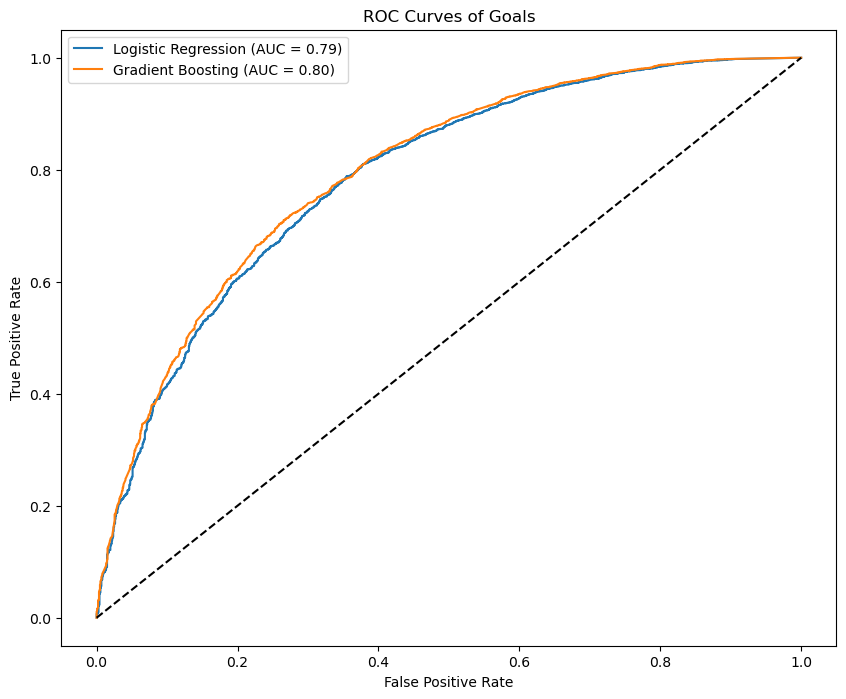

In [7]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['X', 'Y', 'distance_to_goal', 'angle_to_goal']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['shotType', 'situation'])
    ])

# Create pipeline for logistic regression model
log_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

# Create pipeline for gradient boosting model
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier())
])

# Prepare data
features = combined_df_copy[['X', 'Y', 'distance_to_goal', 'angle_to_goal', 'shotType', 'situation']]
target = combined_df_copy['result']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the models
log_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Predict probabilities for test set
log_probs = log_model.predict_proba(X_test)[:,1]
gb_probs = gb_model.predict_proba(X_test)[:,1]

# Calculate ROC curves
log_fpr, log_tpr, _ = roc_curve(y_test, log_probs)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)

# Calculate AUC scores
log_auc = auc(log_fpr, log_tpr)
gb_auc = auc(gb_fpr, gb_tpr)

# Plot ROC curves
plt.figure(figsize=(10, 8))
plt.plot(log_fpr, log_tpr, label=f'Logistic Regression (AUC = {log_auc:.2f})')
plt.plot(gb_fpr, gb_tpr, label=f'Gradient Boosting (AUC = {gb_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves of Goals')
plt.legend()
plt.show()

In [8]:
log_preds = log_model.predict(X_test)
gb_preds = gb_model.predict(X_test)

log_accuracy = accuracy_score(y_test, log_preds)
gb_accuracy = accuracy_score(y_test, gb_preds)

# Print accuracy scores
print(f'Accuracy of logistic regression model: {log_accuracy:.2f}')
print(f'Accuracy of gradient boosting model: {gb_accuracy:.2f}')

Accuracy of logistic regression model: 0.90
Accuracy of gradient boosting model: 0.91


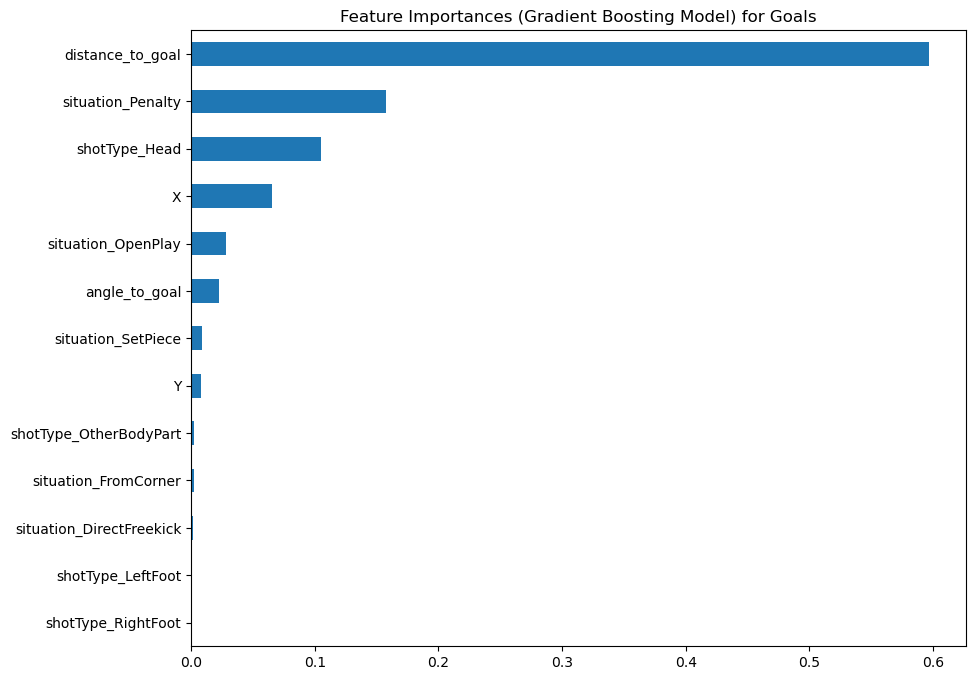

In [9]:
onehot_features = list(features['shotType'].unique()) + list(features['situation'].unique())
onehot_columns = ['shotType_' + feat for feat in features['shotType'].unique()] + ['situation_' + feat for feat in features['situation'].unique()]


feature_importances = pd.Series(gb_model.named_steps['classifier'].feature_importances_, index=['X', 'Y', 'distance_to_goal', 'angle_to_goal'] + onehot_columns)

feature_importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title('Feature Importances (Gradient Boosting Model) for Goals')
plt.show()

to note* = I used another model with gridsearch, but it took too long to run and the tradeoff in accuracy and AUC values werent all that much greater, so I dropped it

# xG model

Linear Regression Performance:
 - RMSE: 0.1166
 - MAE: 0.0752
 - R^2: 0.4514

Gradient Boosting Performance:
 - RMSE: 0.0859
 - MAE: 0.0467
 - R^2: 0.7025



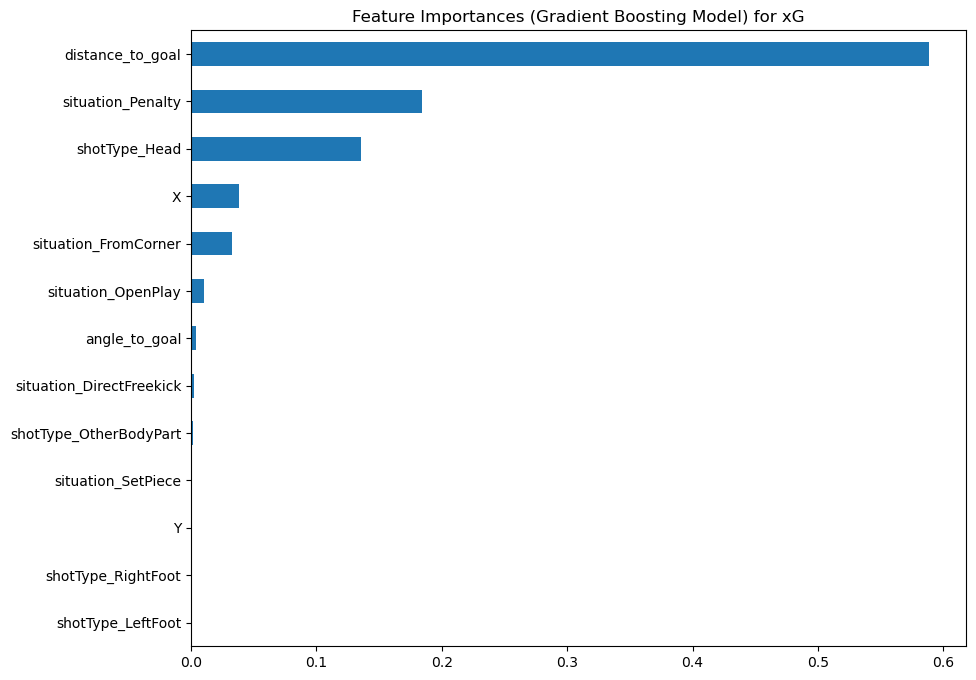

In [10]:
# Define preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', ['X', 'Y', 'distance_to_goal', 'angle_to_goal']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['shotType', 'situation'])
    ])

# Create pipeline for linear regression model
lin_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Create pipeline for gradient boosting model
gb_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', GradientBoostingRegressor())
])

# Prepare data
features = combined_df_copy[['X', 'Y', 'distance_to_goal', 'angle_to_goal', 'shotType', 'situation']]
target = combined_df_copy['xG']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Train the models and print metrics
lin_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

# Predict xG for test set
lin_preds = lin_model.predict(X_test)
gb_preds = gb_model.predict(X_test)

# Calculate and print performance metrics
for model_name, preds in zip(['Linear Regression', 'Gradient Boosting'], [lin_preds, gb_preds]):
    print(f'{model_name} Performance:')
    print(f' - RMSE: {mean_squared_error(y_test, preds, squared=False):.4f}')
    print(f' - MAE: {mean_absolute_error(y_test, preds):.4f}')
    print(f' - R^2: {r2_score(y_test, preds):.4f}\n')

# Get feature names from OneHotEncoder
onehot_encoder = gb_model.named_steps['preprocessor'].named_transformers_['cat']
if hasattr(onehot_encoder, 'get_feature_names_out'):
    onehot_columns = list(onehot_encoder.get_feature_names_out(['shotType', 'situation']))
else:
    onehot_columns = list(onehot_encoder.get_feature_names(['shotType', 'situation']))

# Combine the numeric feature names and onehot_columns
feature_names = ['X', 'Y', 'distance_to_goal', 'angle_to_goal'] + onehot_columns

# Calculate feature importances - GradientBoosting
gb_importances = gb_model.named_steps['regressor'].feature_importances_
gb_feature_importances = pd.Series(gb_importances, index=feature_names)
#print("\nGradient Boosting Feature Importances:")
#print(gb_feature_importances.sort_values(ascending=False))

gb_feature_importances.sort_values().plot(kind='barh', figsize=(10, 8))
plt.title('Feature Importances (Gradient Boosting Model) for xG')
plt.show()

# Calculate feature coefficients - Linear Regression
lin_coeffs = lin_model.named_steps['regressor'].coef_
lin_feature_coeffs = pd.Series(lin_coeffs, index=feature_names)
#print("\nLinear Regression Feature Coefficients:")
#print(lin_feature_coeffs)

The Gradient Boosting (GB) model outperforms the Linear Regression (LR) model across all metrics. With a Root Mean Squared Error (RMSE) of 0.0859, Mean Absolute Error (MAE) of 0.0467, and R^2 of 0.7025, the GB model predicts the Expected Goals (xG) with better accuracy and less error compared to the LR model. The lower RMSE and MAE indicate fewer average residuals/errors in the GB model predictions. The higher R^2 indicates that the GB model can explain 70.25% of the variability in the xG target variable, compared to the LR model's 45.14%.

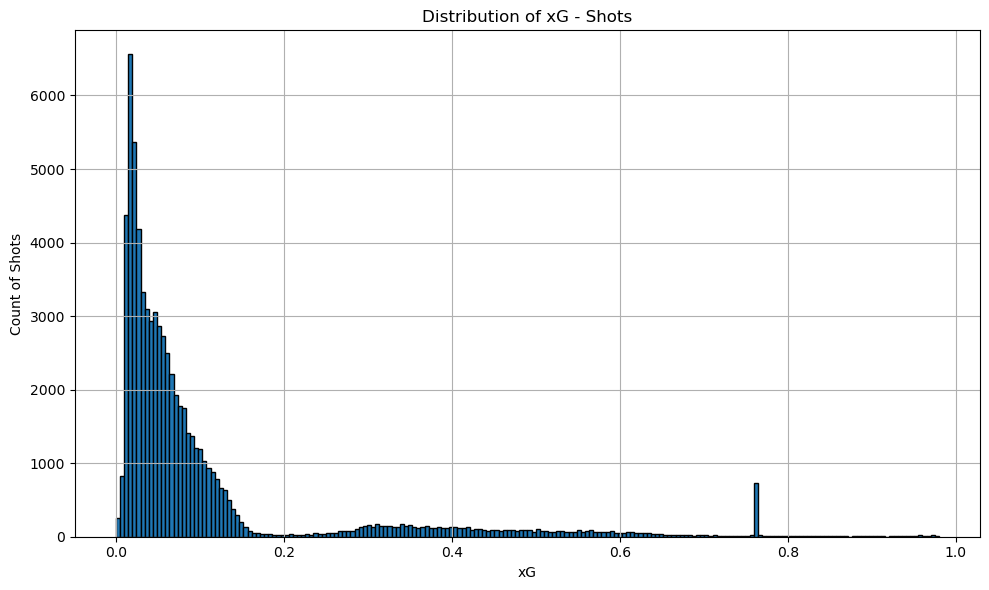

In [11]:
# Create the figure and the axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the histogram of shots based on 'xG'
ax.hist(combined_df['xG'], bins=200, edgecolor='black')
ax.set_title('Distribution of xG - Shots')
ax.set_xlabel('xG')
ax.set_ylabel('Count of Shots')

# Add a grid
ax.grid(True)

plt.tight_layout()
plt.show()

As you can see, most shots are bulked in at around a .02 xG, and there is a spike at around .75 xG, reason for this is penalty shots, which their xG on average is around that

In [12]:
df_teams_data = pd.read_csv('../Downloads/dates_data_cleaned.csv')
df_teams_data

,datetime,home_title,home_score,away_title,away_score,home_xG,away_xG,home_win_%,away_win_%,draw_%
0,2014-08-16 12:45:00,Manchester United,1,Swansea,2,1.166350,0.278076,0.6519,0.0679,0.2802
1,2014-08-16 15:00:00,Leicester,2,Everton,2,1.278300,0.613273,0.5513,0.1565,0.2922
2,2014-08-16 15:00:00,Queens Park Rangers,0,Hull,1,1.900670,1.117570,0.5900,0.1651,0.2449
3,2014-08-16 15:00:00,Stoke,0,Aston Villa,1,0.423368,0.909774,0.1468,0.4895,0.3637
4,2014-08-16 15:00:00,West Bromwich Albion,2,Sunderland,2,1.683430,0.991901,0.5894,0.1430,0.2676
...,...,...,...,...,...,...,...,...,...,...
3415,2023-05-28 15:30:00,Everton,1,Bournemouth,0,1.129330,0.432084,0.5710,0.1260,0.3030
3416,2023-05-28 15:30:00,Leeds,1,Tottenham,4,1.191510,2.033150,0.1833,0.6008,0.2159
3417,2023-05-28 15:30:00,Leicester,2,West Ham,1,2.030130,0.970352,0.6472,0.1422,0.2106
3418,2023-05-28 15:30:00,Manchester United,2,Fulham,1,2.747660,1.881670,0.5742,0.2099,0.2159


In [13]:
df_teams_data['datetime'] = pd.to_datetime(df_teams_data['datetime'])

# since we cant categorize by year, we had to make it so we chose our starting and end months to make our seasons
df_teams_data['season'] = df_teams_data['datetime'].apply(lambda x: x.year if x.month > 7 else x.year - 1)

# Function to calculate stats for a given season
def process_season(df, season):
    df_season = df[df['season'] == season]

    # Get all unique team titles
    team_titles = pd.concat([df_season['home_title'], df_season['away_title']]).unique()

    # Initialize columns
    stats = pd.DataFrame(index=team_titles, 
                         columns=['wins', 'draws', 'losses', 'total G', 'total GA', 'points', 'xG', 'xGA', 'xPTS'])
    stats.fillna(0, inplace=True)

    for _, row in df_season.iterrows():
        home_team = row['home_title']
        away_team = row['away_title']
        home_goals = row['home_score']
        away_goals = row['away_score']
        home_xG = row['home_xG']
        away_xG = row['away_xG']
        home_win_prob = row['home_win_%']
        away_win_prob = row['away_win_%']
        draw_prob = row['draw_%']

        # Update goals scored and conceded
        stats.loc[home_team, 'total G'] += home_goals
        stats.loc[home_team, 'total GA'] += away_goals
        stats.loc[away_team, 'total G'] += away_goals
        stats.loc[away_team, 'total GA'] += home_goals

        # Update xG and xGA
        stats.loc[home_team, 'xG'] += home_xG
        stats.loc[home_team, 'xGA'] += away_xG
        stats.loc[away_team, 'xG'] += away_xG
        stats.loc[away_team, 'xGA'] += home_xG

        # Update wins, losses, draws and points
        if home_goals > away_goals:  # home team wins
            stats.loc[home_team, 'wins'] += 1
            stats.loc[home_team, 'points'] += 3
            stats.loc[away_team, 'losses'] += 1
        elif home_goals < away_goals:  # away team wins
            stats.loc[away_team, 'wins'] += 1
            stats.loc[away_team, 'points'] += 3
            stats.loc[home_team, 'losses'] += 1
        else:  # draw
            stats.loc[home_team, 'draws'] += 1
            stats.loc[home_team, 'points'] += 1
            stats.loc[away_team, 'draws'] += 1
            stats.loc[away_team, 'points'] += 1

        # Update xPTS
        stats.loc[home_team, 'xPTS'] += (home_win_prob * 3.0) + (draw_prob * 1.0)
        stats.loc[away_team, 'xPTS'] += (away_win_prob * 3.0) + (draw_prob * 1.0)

    return stats.sort_values(by=['points', 'total G'], ascending=False)

In [14]:
# Create the dataframes for each season
df_teams_2014 = process_season(df_teams_data, 2014)
df_teams_2015 = process_season(df_teams_data, 2015)
df_teams_2016 = process_season(df_teams_data, 2016)
df_teams_2017 = process_season(df_teams_data, 2017)
df_teams_2018 = process_season(df_teams_data, 2018)
df_teams_2019 = process_season(df_teams_data, 2019)
df_teams_2020 = process_season(df_teams_data, 2020)
df_teams_2021 = process_season(df_teams_data, 2021)
df_teams_2022 = process_season(df_teams_data, 2022)

In [15]:
df_teams_2022

,wins,draws,losses,total G,total GA,points,xG,xGA,xPTS
Manchester City,28,5,5,94,33,89,84.321567,34.208415,83.0423
Arsenal,26,6,6,88,43,84,76.512308,45.163392,72.5338
Manchester United,23,6,9,58,43,75,71.901178,50.287639,66.3995
Newcastle United,19,14,5,68,33,71,76.977056,41.856248,71.6661
Liverpool,19,10,9,75,47,67,80.771997,55.773338,67.3693
Brighton,18,8,12,72,53,62,77.723422,50.154518,70.8574
Aston Villa,18,7,13,51,46,61,49.995345,53.955537,54.3668
Tottenham,18,6,14,70,63,60,57.833790,51.660728,57.6018
Brentford,15,14,9,58,46,59,59.227045,51.453067,58.2648
Fulham,15,7,16,55,53,52,47.984977,71.490811,39.2370


In [16]:
# List of all our dataframes and their respective years
df_list = [(df_teams_2014, 2014), (df_teams_2015, 2015), (df_teams_2016, 2016),
           (df_teams_2017, 2017), (df_teams_2018, 2018), (df_teams_2019, 2019),
           (df_teams_2020, 2020), (df_teams_2021, 2021), (df_teams_2022, 2022)]

# Process each dataframe
for df, year in df_list:
    # Reset the index so that 'Team' becomes a column and explicitly name it 'Team'
    df.reset_index(inplace=True)
    df = df.rename(columns={'index': 'Team'})

    # Add the 'Year' column
    df['Year'] = year

    # Add the 'Position' column. Add 1 because Python uses 0-based indexing
    df['Position'] = df.index + 1

# Concatenate all the dataframes into a single dataframe
df_positions = pd.concat([df for df, year in df_list])

In [17]:
df_positions

,index,wins,draws,losses,total G,total GA,points,xG,xGA,xPTS
0,Chelsea,26,9,3,73,32,87,68.643320,31.524344,75.3172
1,Manchester City,24,7,7,83,38,79,75.815441,40.499403,73.0982
2,Arsenal,22,9,7,71,36,75,69.802591,35.718825,75.1740
3,Manchester United,20,10,8,62,37,70,54.206860,39.842347,63.0327
4,Tottenham,19,7,12,58,53,64,52.385284,57.044148,48.9361
...,...,...,...,...,...,...,...,...,...,...
15,Nottingham Forest,9,11,18,38,68,38,39.574460,68.459309,35.0461
16,Everton,8,12,18,34,57,36,48.649836,68.582862,40.7132
17,Leicester,9,7,22,51,68,34,48.986999,59.789351,45.0736
18,Leeds,7,10,21,48,78,31,47.795965,69.581033,40.5808


C:\Users\chrys\AppData\Local\Temp\ipykernel_8992\1507631830.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_stats.dropna(inplace=True)  # Drop rows with missing values


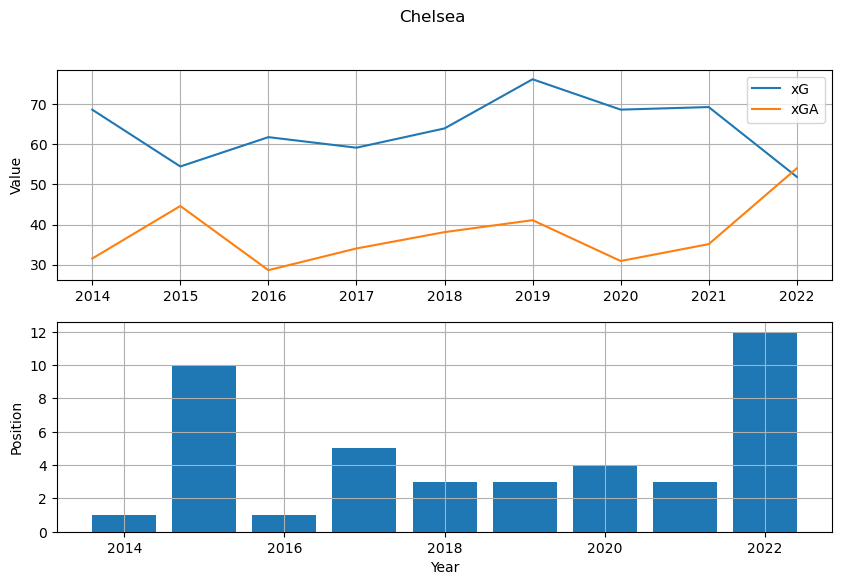

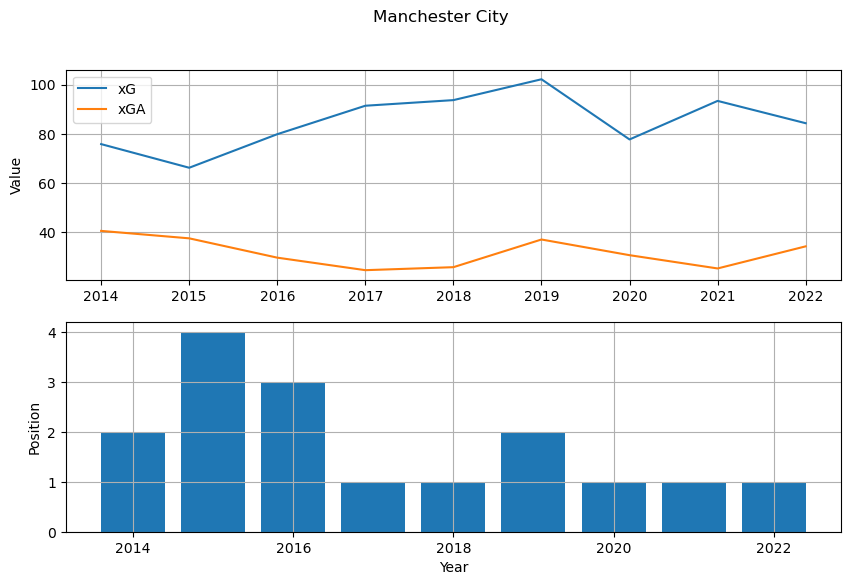

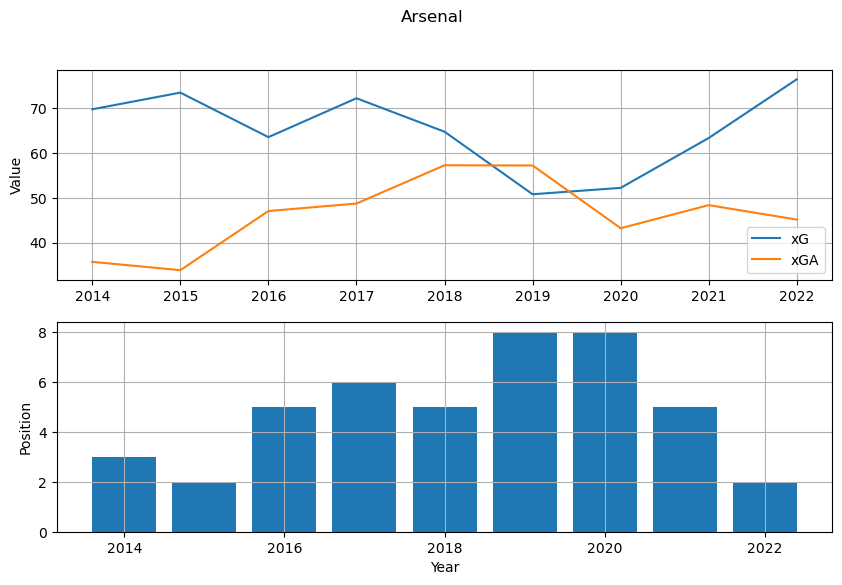

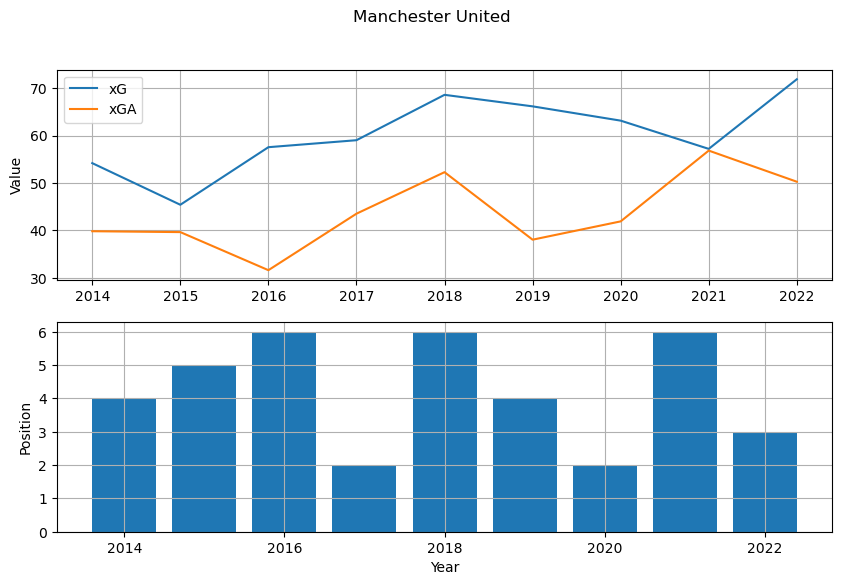

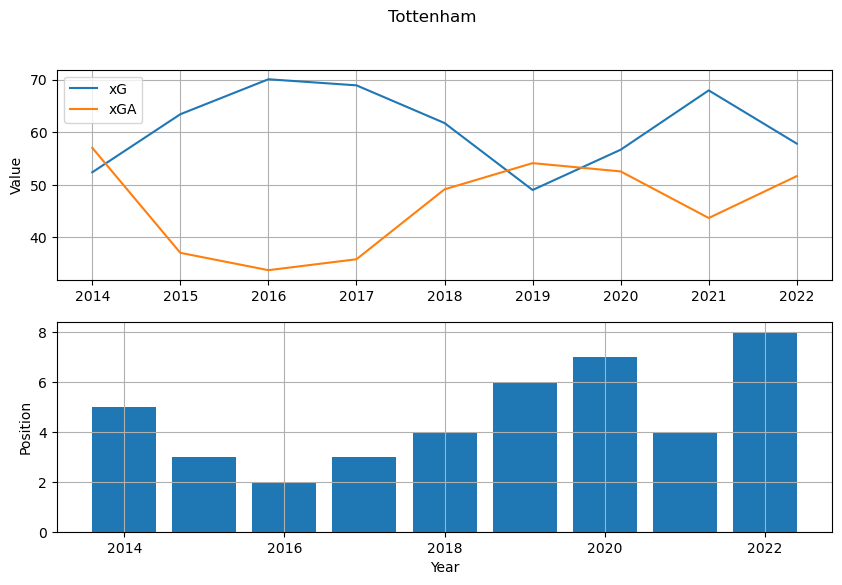

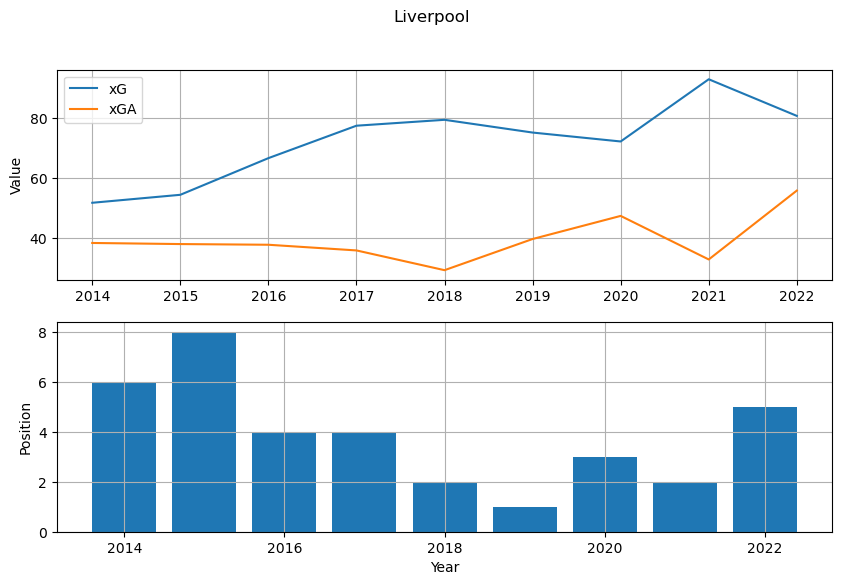

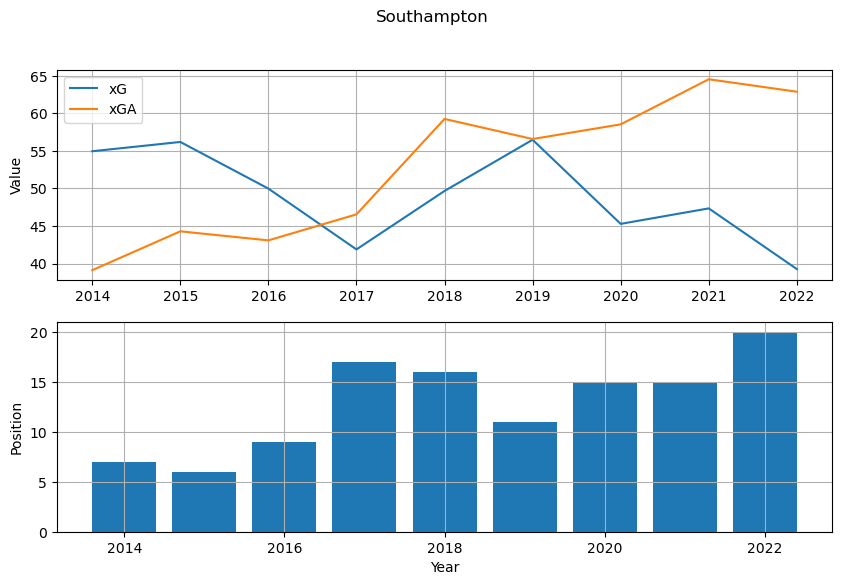

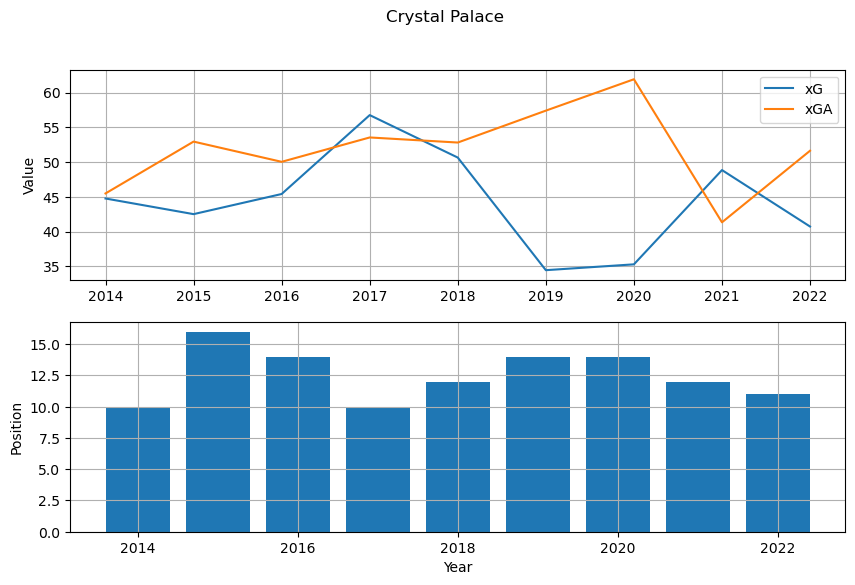

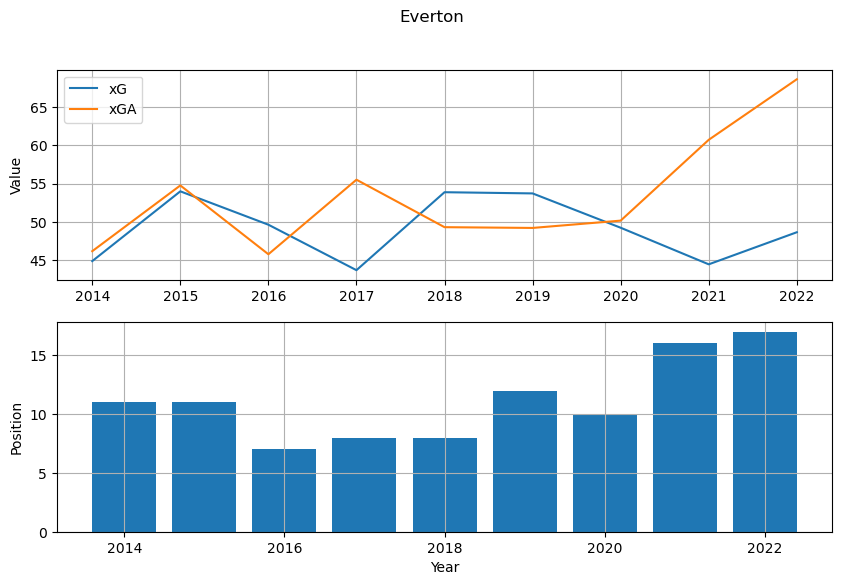

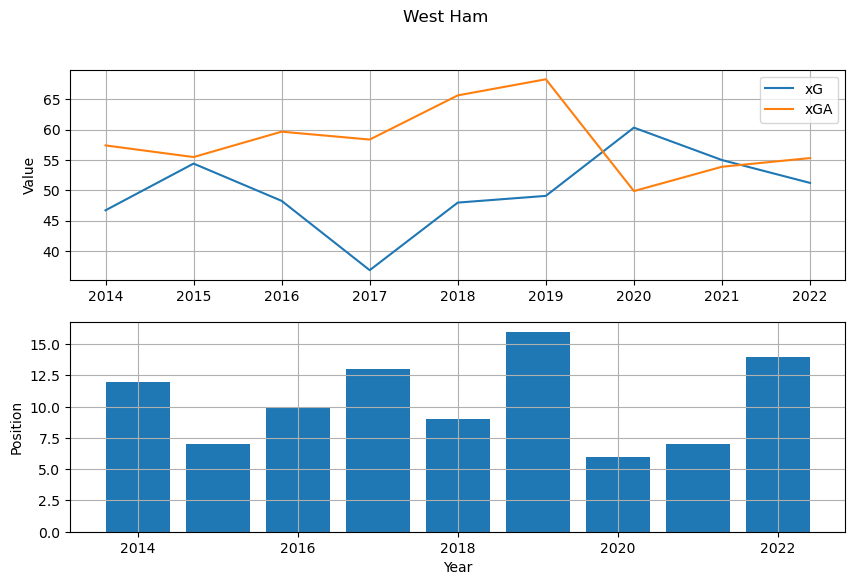

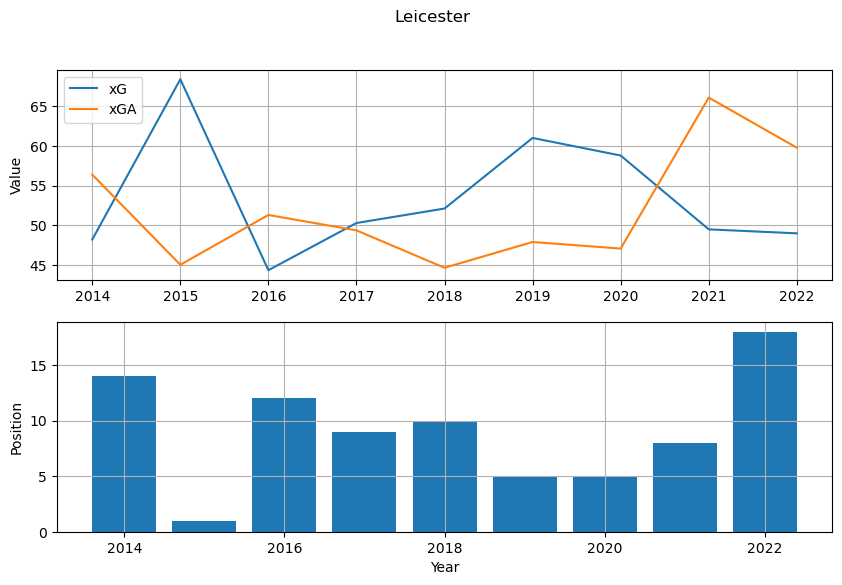

In [18]:
full_years = set(range(2014, 2023))  # Set of all years

# Compile all team data into a single DataFrame
df_list = [df_teams_2014, df_teams_2015, df_teams_2016, df_teams_2017, df_teams_2018, 
           df_teams_2019, df_teams_2020, df_teams_2021, df_teams_2022]

for i, df in enumerate(df_list):
    df['Year'] = 2014 + i  # Add a column for the year
    df['Position'] = df.index + 1  # Add a column for the position

df_positions = pd.concat(df_list, ignore_index=True)
df_positions.dropna(inplace=True)  # Drop rows with missing values

# Generate stats DataFrame
df_stats = df_positions[['index', 'Year', 'xG', 'xGA']]
df_stats.dropna(inplace=True)  # Drop rows with missing values

# Plot data for each team
for team in df_stats['index'].unique():
    df_team_stats = df_stats[df_stats['index'] == team]
    df_team_positions = df_positions[df_positions['index'] == team]
    
    # Check if the team has data for all years
    team_years_stats = set(df_team_stats['Year'])
    team_years_positions = set(df_team_positions['Year'])
    
    if team_years_stats == full_years and team_years_positions == full_years:
        # Only plot the team if they have data for all years
        fig, axs = plt.subplots(2, figsize=(10, 6)) 
        fig.suptitle(team)
    
        axs[0].plot(df_team_stats['Year'], df_team_stats['xG'], label='xG')
        axs[0].plot(df_team_stats['Year'], df_team_stats['xGA'], label='xGA')
        axs[0].legend()
        axs[0].set_ylabel('Value')
        axs[0].grid(True)  
    
        axs[1].bar(df_team_positions['Year'], df_team_positions['Position'], align='center')
        axs[1].set_ylabel('Position')
        axs[1].set_xlabel('Year')
        axs[1].grid(True) 
    
        plt.show()


Only 11 teams have stayed in the premier league throughout the 2014/2015-2022/2023 seasons, the rest have fluctuated in and out of the premier league and its lower divisions, called the EFL. At the end of each season, the top three teams in each league go up a league for the next season, and the bottom three drop down a league. So these 11 teams have consistently made it in the top 17 of their league each year.

In [19]:
df_transfer_data = pd.read_csv('../Downloads/transfer_data.csv')
df_transfer_data

,Club,14/15,15/16,16/17,17/18,18/19,19/20,20/21,21/22,22/23
0,Arsenal,-91.18,-24.00,-102.65,9.15,-71.05,-107.15,-66.85,-136.00,-168.56
1,Aston Villa,-345.63,-12.14,-1.85,-39.70,15.03,-2.95,-156.50,-2.80,-46.14
2,Chelsea,5.11,-9.01,-23.90,-65.90,-125.55,112.27,-190.05,30.94,-543.66
3,Crystal Palace,-241.59,-28.35,-23.40,-51.00,-45.95,-11.50,47.78,-2.40,-85.62
4,Everton,-38.26,-37.20,-25.20,-76.82,-71.15,-33.20,-69.95,6.50,25.40
5,Liverpool,-52.16,-35.95,5.48,10.85,-140.88,37.60,-66.85,-57.45,-56.60
6,Manchester City,-72.50,-141.03,-180.90,-226.15,-20.99,-95.82,-109.40,-45.10,11.67
7,Manchester United,-148.65,-55.33,-137.75,-152.90,-52.15,-155.62,-64.30,-110.90,-230.03
8,Newcastle United,-21.15,-102.28,36.63,-25.28,-8.70,-37.26,-38.73,-130.50,-171.29
9,Nottingham Forest,0.40,9.50,14.14,9.85,-17.93,9.75,0.61,-6.12,-190.25


In [20]:
# List of teams to keep
teams = ['Chelsea', 'Manchester City', 'Arsenal', 'Manchester United', 
         'Tottenham', 'Liverpool', 'Southampton', 'Crystal Palace', 'Everton', 'West Ham', 'Leicester']

# Keep only rows for the teams in the list
df_transfer_data = df_transfer_data[df_transfer_data['Club'].isin(teams)]

df_transfer_data

,Club,14/15,15/16,16/17,17/18,18/19,19/20,20/21,21/22,22/23
0,Arsenal,-91.18,-24.00,-102.65,9.15,-71.05,-107.15,-66.85,-136.00,-168.56
2,Chelsea,5.11,-9.01,-23.90,-65.90,-125.55,112.27,-190.05,30.94,-543.66
3,Crystal Palace,-241.59,-28.35,-23.40,-51.00,-45.95,-11.50,47.78,-2.40,-85.62
4,Everton,-38.26,-37.20,-25.20,-76.82,-71.15,-33.20,-69.95,6.50,25.40
5,Liverpool,-52.16,-35.95,5.48,10.85,-140.88,37.60,-66.85,-57.45,-56.60
6,Manchester City,-72.50,-141.03,-180.90,-226.15,-20.99,-95.82,-109.40,-45.10,11.67
7,Manchester United,-148.65,-55.33,-137.75,-152.90,-52.15,-155.62,-64.30,-110.90,-230.03
10,Tottenham,-4.33,16.25,-31.20,-17.20,5.35,-86.00,-97.20,-61.28,-139.15
11,West Ham,-30.75,-34.19,-42.50,12.22,-87.14,-64.32,-9.29,-70.27,-172.45
13,Leicester,-22.86,-40.45,-26.05,-33.75,-18.80,-15.80,-5.63,-63.60,33.40


In [21]:
def plot_expenditure_vs_points(season_str, df_transfer, df_season):
    # Reset the index of df_season
    df_season = df_season.reset_index()
    
    # Rename the column if necessary
    df_season = df_season.rename(columns={'index': 'Club'})

    # Merge transfer data with team data
    df = pd.merge(df_season, df_transfer[['Club', season_str]], how='left', left_on='Club', right_on='Club')
    
    # Plot the data
    plt.figure(figsize=(6, 4))
    plt.scatter(df[season_str], df['points'])
    
    # Annotate
    for i, txt in enumerate(df['Club']):
        plt.annotate(txt, (df[season_str].iat[i], df['points'].iat[i]))
    
    plt.xlabel('Net Expenditure')
    plt.ylabel('Points')
    plt.title(f'Season {season_str}: Points vs Net Expenditure')
    plt.grid(False)
    plt.show()

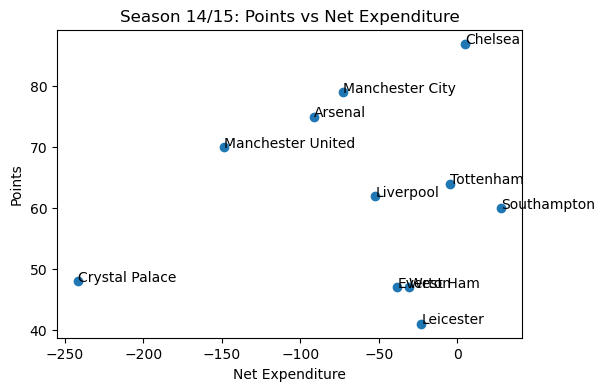

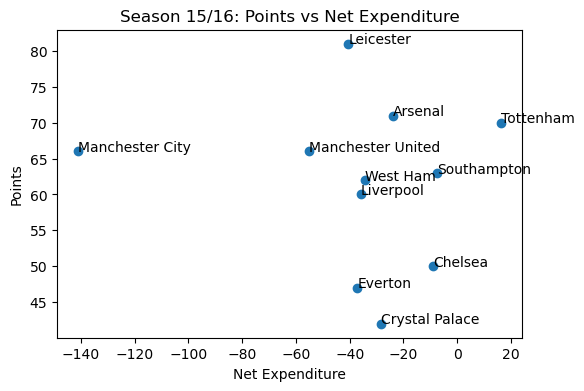

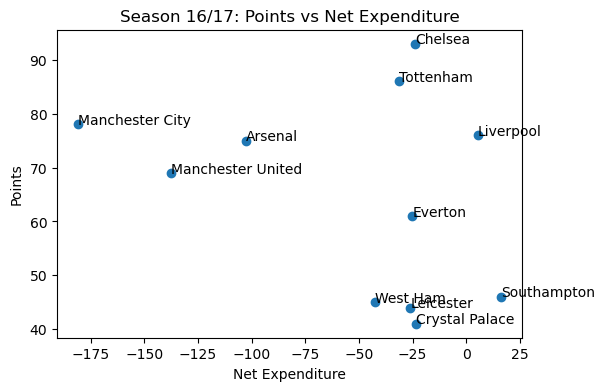

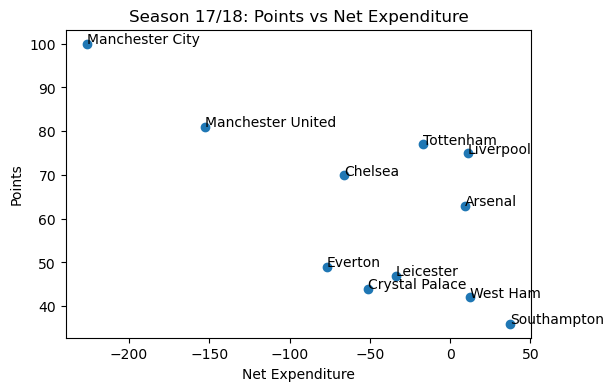

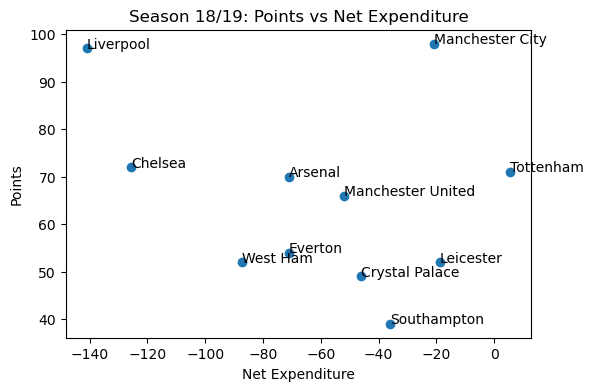

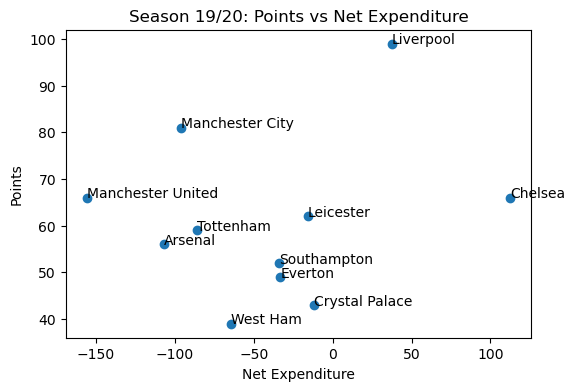

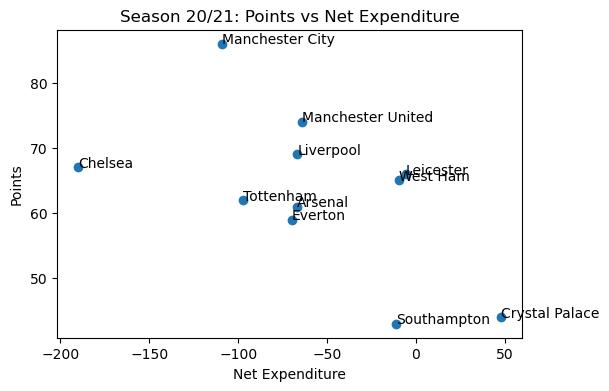

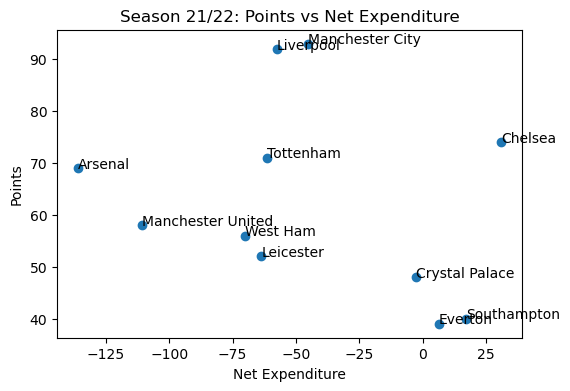

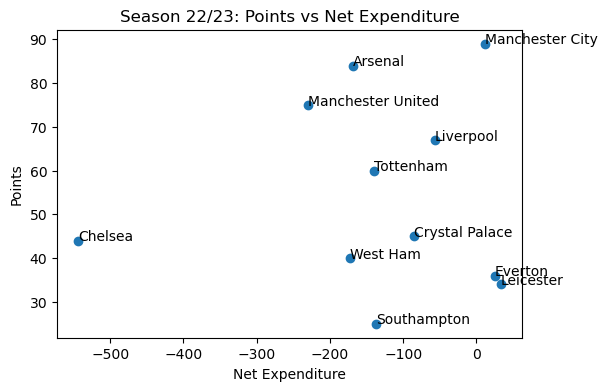

In [22]:
# Put all dataframes into a dictionary
df_dict = {
    '14/15': df_teams_2014,
    '15/16': df_teams_2015,
    '16/17': df_teams_2016,
    '17/18': df_teams_2017,
    '18/19': df_teams_2018,
    '19/20': df_teams_2019,
    '20/21': df_teams_2020,
    '21/22': df_teams_2021,
    '22/23': df_teams_2022
}

# Iterate over the dictionary and generate plots for each season
for season_str, df_season in df_dict.items():
    plot_expenditure_vs_points(season_str, df_transfer_data, df_season)

In [23]:
def plot_total_expenditure_vs_points_regression(df_transfer, df_dict):
    # Create a DataFrame to hold total expenditure and points for each team
    df_total = pd.DataFrame()

    # For each season, add the team's expenditure and points to df_total
    for season_str, df_season in df_dict.items():
        df_temp = df_season.reset_index().merge(df_transfer[['Club', season_str]], how='left', left_on='index', right_on='Club')
        df_temp = df_temp[['Club', season_str, 'points']].rename(columns={season_str: 'expenditure'})
        df_temp['expenditure'] = pd.to_numeric(df_temp['expenditure'], errors='coerce')
        df_total = pd.concat([df_total, df_temp])

    # Group by Club and sum expenditure and points
    df_total = df_total.groupby('Club').sum().reset_index()

    # Create linear regression object
    regr = LinearRegression()

    # Prepare data for regression
    X = df_total['expenditure'].values.reshape(-1, 1)
    y = df_total['points'].values.reshape(-1, 1)

    # Train the model using the training sets
    regr.fit(X, y)

    # Make predictions using the testing set
    y_pred = regr.predict(X)

    # Plot the data
    plt.figure(figsize=(10, 8))
    plt.scatter(X, y, color='black')
    plt.plot(X, y_pred, color='blue', linewidth=3)
    plt.xlabel('Net Expenditure')
    plt.ylabel('Points')
    plt.title('Net Expenditure vs Points across all seasons')

    # Print the coefficients
    print('Coefficients: \n', regr.coef_)

Coefficients: 
 [[-0.25579996]]


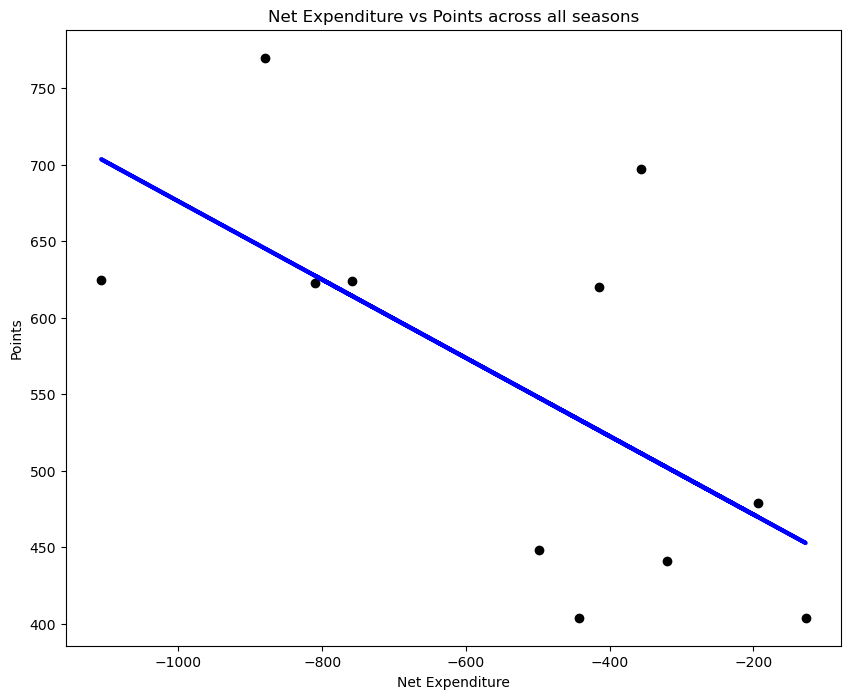

In [24]:
plot_total_expenditure_vs_points_regression(df_transfer_data, df_dict)

so what does this mean? This means that as a team decreases its spending, its points should decrease for that season as well. Meaning that teams that spend more on average should place higher in the league, or get more points. There are obviously some outliers here, where we have seen teams like Leicester in 2015 when they won the league, Chelsea this year spending the most and finished 12th, etc. 

In [25]:
df_players = pd.read_csv('../Downloads/players_data_cleaned.csv')
df_players_best_goals = df_players.sort_values(by=['goals', 'xG'], ascending=False)
df_players_best_goals.head(30)
# players who scored the most goals

,player_name,goals,xG,Actual to xG,Goals to xG %,assists,xA,Assists to xA %,Actual to xA,year
4201,Erling Haaland,36,32.761400,3.238600,9.885415,8,5.849110,36.772948,2.150890,2022
1605,Mohamed Salah,32,25.136493,6.863507,27.304953,10,8.344479,19.839718,1.655521,2017
1606,Harry Kane,30,26.859878,3.140122,11.690753,2,3.820443,-47.650047,-1.820443,2017
4202,Harry Kane,30,23.064440,6.935560,30.070359,3,7.547408,-60.251253,-4.547408,2022
1081,Harry Kane,29,19.820083,9.179917,46.316241,7,5.553894,26.037704,1.446106,2016
0,Sergio Agüero,26,25.270176,0.729824,2.888086,8,5.568927,43.654255,2.431073,2014
531,Harry Kane,25,22.732072,2.267928,9.976775,1,3.088513,-67.621954,-2.088513,2015
1082,Romelu Lukaku,25,16.665464,8.334536,50.010822,6,5.440815,10.277597,0.559185,2016
533,Jamie Vardy,24,22.135412,1.864588,8.423553,6,6.267153,-4.262756,-0.267153,2015
532,Sergio Agüero,24,20.077226,3.922774,19.538426,2,2.028760,-1.417594,-0.028760,2015


In [26]:
df_players_best_xG = df_players.sort_values(by=['Actual to xG', 'Goals to xG %'], ascending=False)
df_players_best_xG.head(30)
# players who overperformed in compared to xG

,player_name,goals,xG,Actual to xG,Goals to xG %,assists,xA,Assists to xA %,Actual to xA,year
1081,Harry Kane,29,19.820083,9.179917,46.316241,7,5.553894,26.037704,1.446106,2016
3669,Kevin De Bruyne,15,5.949964,9.050036,152.102347,8,11.260171,-28.953122,-3.260171,2021
1082,Romelu Lukaku,25,16.665464,8.334536,50.010822,6,5.440815,10.277597,0.559185,2016
1092,Fernando Llorente,15,8.028608,6.971392,86.831899,1,2.090566,-52.166059,-1.090566,2016
4202,Harry Kane,30,23.064440,6.935560,30.070359,3,7.547408,-60.251253,-4.547408,2022
1605,Mohamed Salah,32,25.136493,6.863507,27.304953,10,8.344479,19.839718,1.655521,2017
2649,Mason Greenwood,10,3.387857,6.612143,195.171861,1,1.411508,-29.153776,-0.411508,2019
2627,Danny Ings,22,15.659721,6.340279,40.487820,2,2.849086,-29.802050,-0.849086,2019
1083,Alexis Sánchez,24,17.724456,6.275544,35.406131,10,8.988115,11.258037,1.011885,2016
1093,Son Heung-Min,14,7.765332,6.234668,80.288497,6,4.696416,27.756997,1.303584,2016


In [27]:
df_players_2022_age = pd.read_csv('../Downloads/df_players_w_age_2022.csv')
df_players_2022_age.head(20)

,player_name,goals,xG,Actual to xG,Goals to xG %,assists,xA,Assists to xA %,Actual to xA,year,age
0,Erling Haaland,36,32.761400,3.238600,9.885415,8,5.849110,36.772948,2.150890,2022,22.0
1,Harry Kane,30,23.064440,6.935560,30.070359,3,7.547408,-60.251253,-4.547408,2022,29.0
2,Ivan Toney,20,21.691198,-1.691198,-7.796700,4,4.909893,-18.531827,-0.909893,2022,26.0
3,Mohamed Salah,19,23.340064,-4.340064,-18.594909,12,8.720246,37.610803,3.279754,2022,30.0
4,Callum Wilson,18,18.856768,-0.856768,-4.543557,5,3.567963,40.135965,1.432037,2022,30.0
5,Marcus Rashford,17,18.761761,-1.761761,-9.390166,5,3.735413,33.854010,1.264587,2022,24.0
6,Martin Odegaard,15,9.137761,5.862239,64.154000,7,9.209957,-23.995299,-2.209957,2022,23.0
7,Gabriel Martinelli,15,10.538134,4.461866,42.340185,5,9.349485,-46.521121,-4.349485,2022,21.0
8,Ollie Watkins,15,17.486296,-2.486296,-14.218539,6,3.674034,63.308233,2.325966,2022,26.0
9,Aleksandar Mitrovic,14,16.179017,-2.179017,-13.468166,1,2.334498,-57.164243,-1.334498,2022,28.0


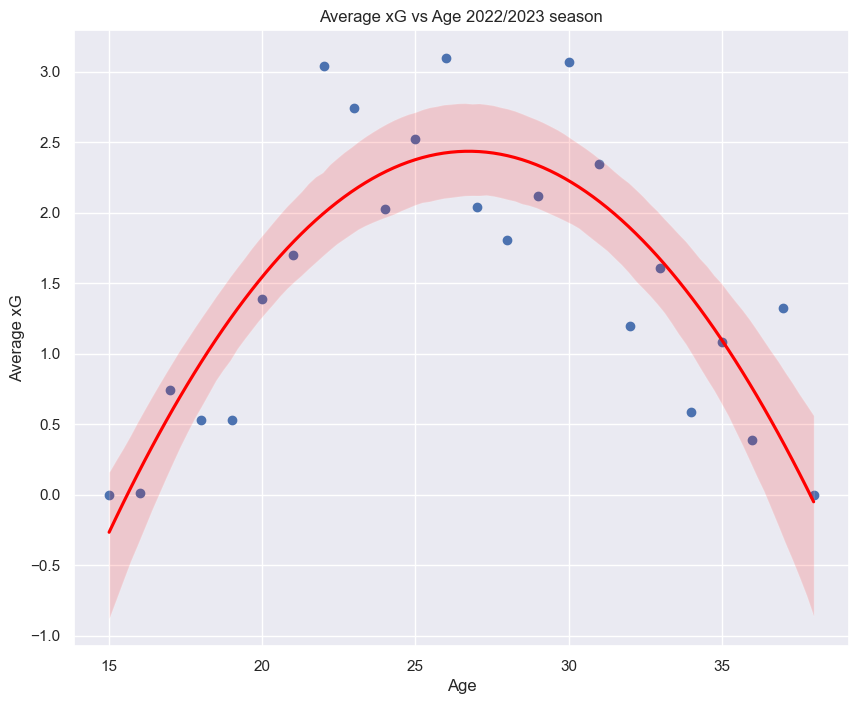

In [28]:
# group by age and calculate the average xG for each age
df_avg_xg = df_players_2022_age.groupby('age')['xG'].mean().reset_index()

plt.figure(figsize=(10, 8))

sns.set()

# scatter plot of average xG vs age
plt.scatter(df_avg_xg['age'], df_avg_xg['xG'], alpha=1)

# plot regression line with order 2
sns.regplot(x='age', y='xG', data=df_avg_xg, scatter=False, color='red', order=2, line_kws={'label':'Average'})

plt.xlabel('Age')
plt.ylabel('Average xG')
plt.title('Average xG vs Age 2022/2023 season')
#plt.legend()
plt.show()

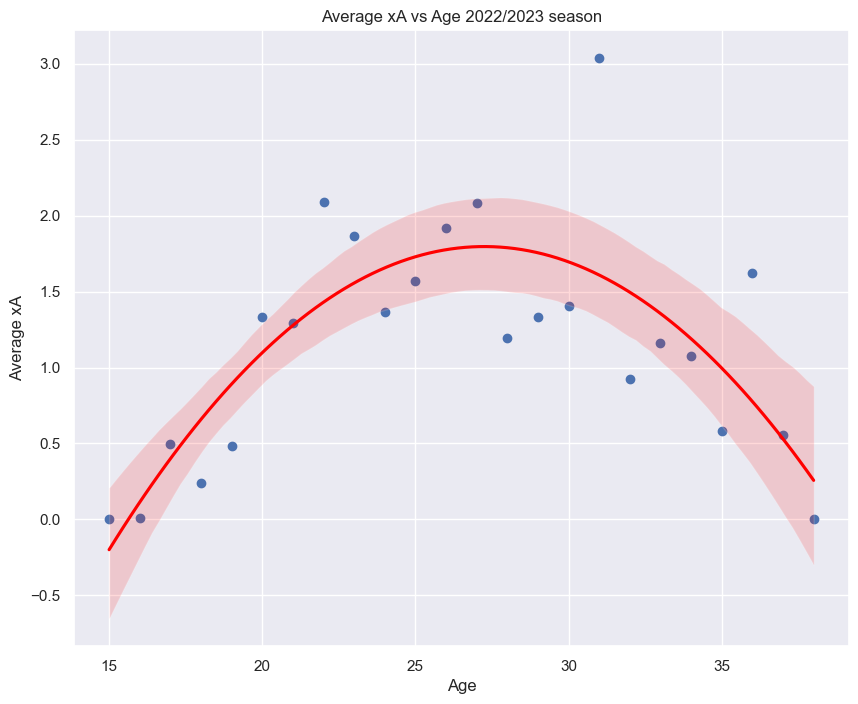

In [29]:
# group by age and calculate the average xA for each age
df_avg_xA = df_players_2022_age.groupby('age')['xA'].mean().reset_index()

plt.figure(figsize=(10, 8))

sns.set()

# scatter plot of average xA vs age
plt.scatter(df_avg_xA['age'], df_avg_xA['xA'], alpha=1)

# plot regression line with order 2
sns.regplot(x='age', y='xA', data=df_avg_xA, scatter=False, color='red', order=2, line_kws={'label':'Average'})

plt.xlabel('Age')
plt.ylabel('Average xA')
plt.title('Average xA vs Age 2022/2023 season')
#plt.legend()
plt.show()

So looking at the grpahs, even though we took a one season sample, it still gives us some insight on player perfomance with age. It seems that xG, with a naturally higher average over xA, declines a lot sharper with age, where goal scoring chances and ability does rely heavily on physical traits, where assists dont as much. We can see that both very "young" and "old" players will eventually have the same xG output with age, but a young player will usually not generate as much xA as an older player, since some of the best playmakers were even performing in their late years. Also we seem to have outliers around the 30 year of age mark, and this is home to some of the best players in the premier league being around that age!

only took 1 seasons worth of data because the scraping had to be done manually for age, not worth it for all years

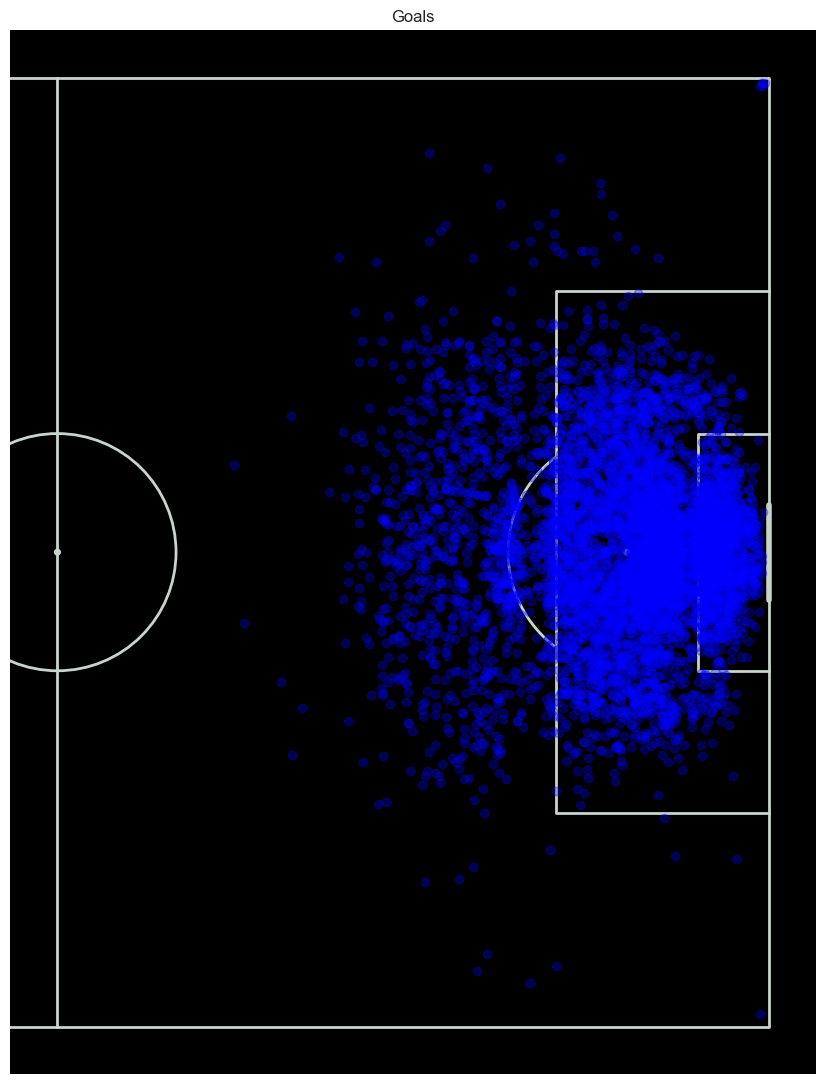

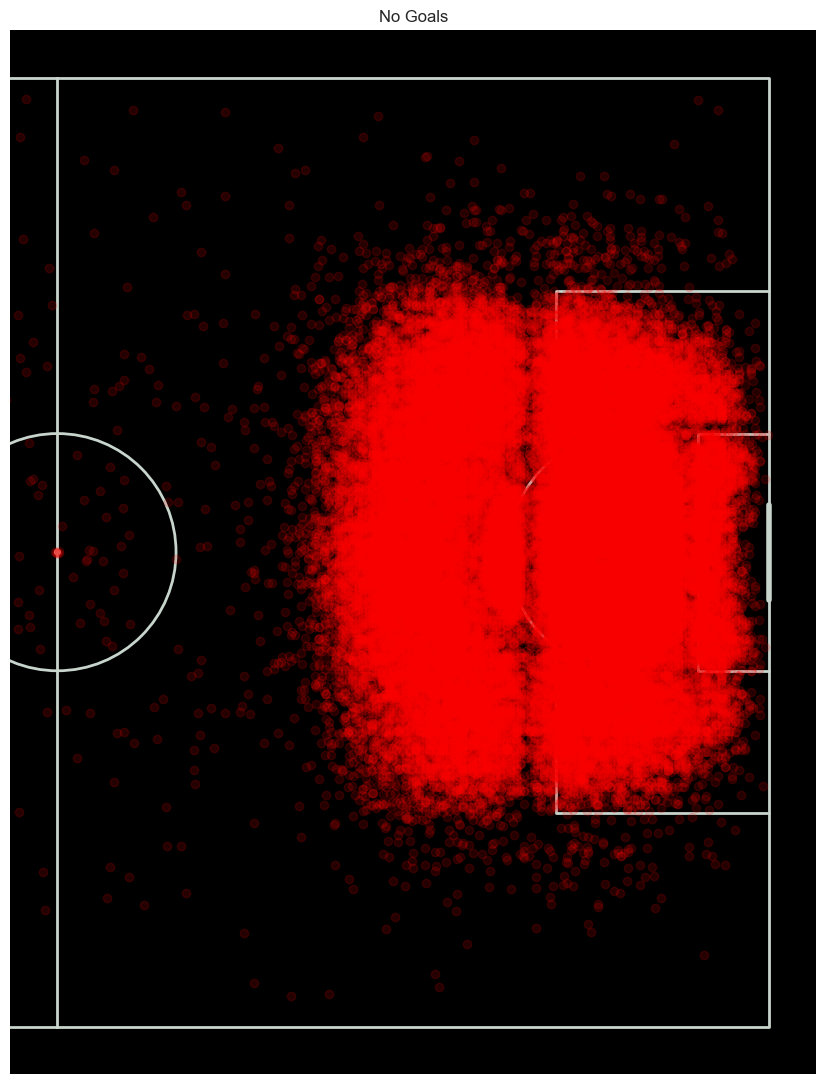

In [30]:
# Filter dataframe for goals and no goals
df_goals = combined_df[combined_df['result'] == 0]
df_no_goals = combined_df[combined_df['result'] == 1]

# Create the pitch for goals
pitch = Pitch(pitch_type='statsbomb', half = True,
              pitch_color='black', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize = (16, 11))

# Plot the goals using a scatter plot
scatter = ax.scatter(df_goals['X']*pitch.dim.pitch_length, 
                     pitch.dim.pitch_width - df_goals['Y']*pitch.dim.pitch_width, # invert y for mplsoccer pitch orientation
                     color='blue', alpha=0.3)
plt.title('Goals')
plt.show()

# Create the pitch for no goals
pitch = Pitch(pitch_type='statsbomb', half = True,
              pitch_color='black', line_color='#c7d5cc')
fig, ax = pitch.draw(figsize = (16, 11))

# Plot the no goals using a scatter plot
scatter = ax.scatter(df_no_goals['X']*pitch.dim.pitch_length, 
                     pitch.dim.pitch_width - df_no_goals['Y']*pitch.dim.pitch_width, # invert y for mplsoccer pitch orientation
                     color='red', alpha=0.15)
plt.title('No Goals')
plt.show()

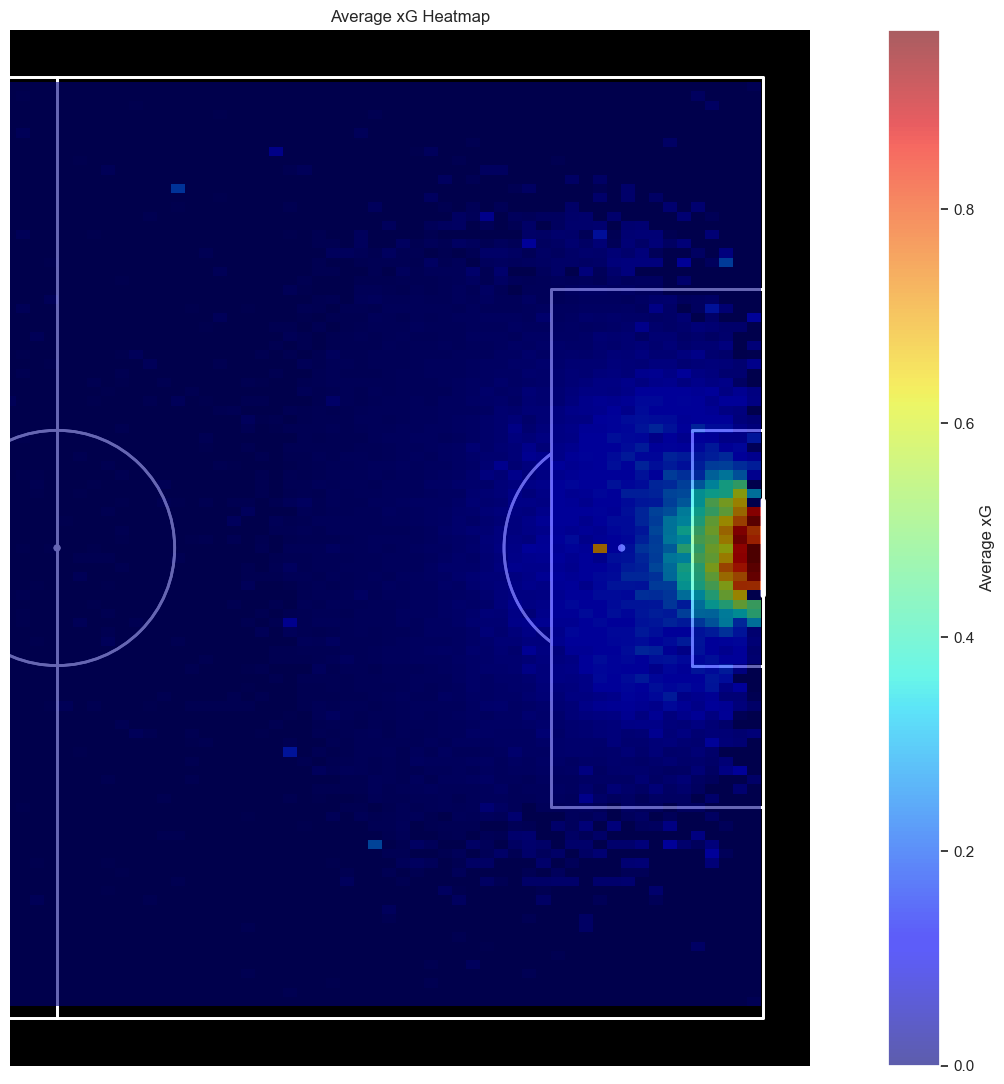

In [31]:
from scipy.stats import binned_statistic_2d
import numpy as np

# Convert X and Y to pitch units
combined_df['X_pitch'] = combined_df['X']*pitch.dim.pitch_length
combined_df['Y_pitch'] = pitch.dim.pitch_width - combined_df['Y']*pitch.dim.pitch_width  # invert y for mplsoccer pitch orientation

# Define the number of bins
num_bins_x = num_bins_y = 100

# Calculate the average xG in each bin
statistic, x_edges, y_edges, bin_number = binned_statistic_2d(
    x=combined_df['X_pitch'],
    y=combined_df['Y_pitch'],
    values=combined_df['xG'],
    statistic='mean',
    bins=[num_bins_x, num_bins_y]
)

# Create a 2D array of the average xG
avg_xg_grid = np.nan_to_num(statistic)

# Create the pitch
pitch = Pitch(pitch_type='statsbomb', half = True,
              pitch_color='black', line_color='white')

# Draw the pitch
fig, ax = pitch.draw(figsize = (16, 11))

# Create a heatmap of the average xG
pcm = ax.pcolormesh(x_edges, y_edges, avg_xg_grid.T, cmap='jet', alpha=0.6)  # Transpose the avg_xg_grid because pcolormesh uses a different coordinate system

# Draw pitch lines on top of the heatmap
pitch.draw(ax=ax)

# Add a colorbar to the plot
fig.colorbar(pcm, ax=ax, label='Average xG')

plt.title('Average xG Heatmap')
plt.show()

# Concluding Thoughts

In conclusion:

- xG is one of the most important metrics in soccer

- The new advanced analytics era coming to fruition is justified, its a great predictor of quality shots vs bad ones, goal prediction, etc.

- We saw shot distance played the biggest role in goal scoring and xG

- xG and xGA play a big role in points and standings

- Team spending leads to more points, so its crucial to spend on valuable players

- Age impacts xG the most compared to xA, teams should consider that

# Problems and/or things I could have done

- Lack of free soccer data, everything sports data related nowadays is behind paywalls, epscially the sites that have super important metrics or clean/filtered data. 

- Due to problem above, spent too much time data scraping and cleaning data. Took a majority of my project time.

- I could have done more with my goal and xG model, like use it to predict future values 

- Made better visualisations and a powerpoint

- Explore further with data collected, maybe try to get ages across all 9 seasons to use that data